# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

In [ ]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
import pandas as pd

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [105]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.70.140.45',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [106]:
cursor = con.cursor()

In [56]:
sql = """
SELECT MAX(hire_date) as max_date, MIN(hire_date) as min_date
FROM employees 
"""


In [57]:
sql

'\nSELECT MAX(hire_date) as max_date, MIN(hire_date) as min_date\nFROM employees \n'

In [36]:
cursor.execute(sql)

In [37]:
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [5]:
cursor = con.cursor()

In [6]:
sql_salary = """
SELECT 
    emp_no, 
    salary, 
    from_date, 
    to_date
FROM salaries
WHERE (emp_no, to_date, from_date) IN (
    SELECT emp_no, MAX(to_date) AS max_date, MAX(from_date) AS max_from_date
    FROM salaries
    GROUP BY emp_no
)
"""

In [7]:
cursor.execute(sql_salary)

In [8]:
res = pd.DataFrame(cursor.fetchall(), columns = ['emp_no', 'salary', 'from_date', 'to_date'])

In [32]:
field_names = [i[0] for i in cursor.description]

In [33]:
field_names

['emp_no', 'salary', 'from_date', 'to_date']

In [9]:
res.shape

(300024, 4)

In [153]:
res.head(3)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


In [154]:
res.columns

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

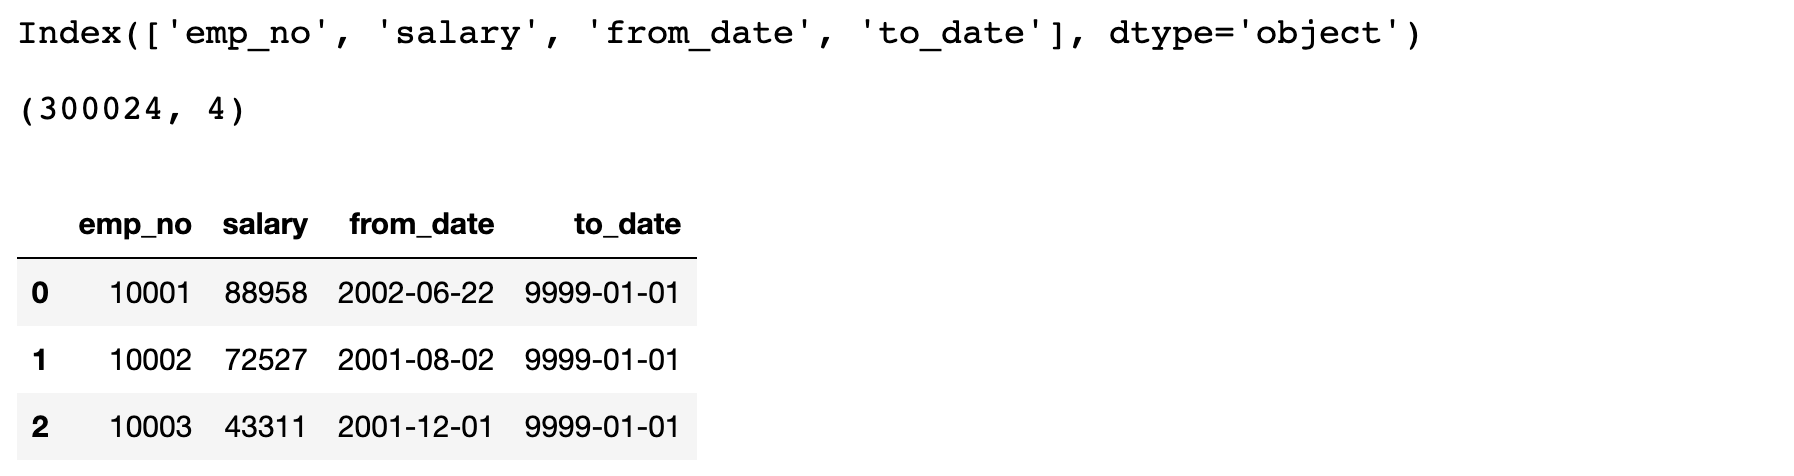

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [10]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

In [100]:
type(res['to_date'])

pandas.core.series.Series

In [12]:
res_filtered = res[res.to_date == datetime.date(9999, 1, 1)]

In [15]:
res_filtered['to_date'].count()  # у нас 240124 

240124

In [14]:
res['to_date'].value_counts()

to_date
9999-01-01    240124
2000-01-19        36
2000-07-15        35
2000-05-31        34
2001-05-24        33
               ...  
1986-07-13         1
1985-06-08         1
1987-11-01         1
1988-05-16         1
1987-08-25         1
Name: count, Length: 5879, dtype: int64

In [37]:
res.salary.max()

158220

6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [33]:
from matplotlib import pyplot as plt
import numpy as np

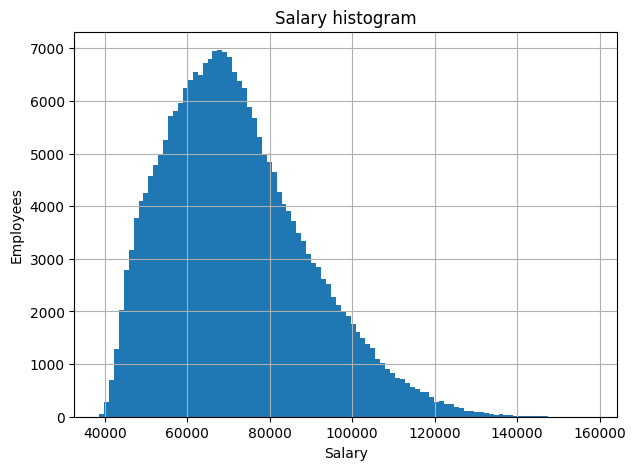

In [39]:
res_filtered['salary'].hist(figsize=(7, 5), bins=100);
plt.title('Salary histogram');
plt.xlabel('Salary')
plt.ylabel('Employees');

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [51]:
sql_hire ="""
SELECT DISTINCT YEAR(hire_date) AS hire_date, COUNT(*) AS emp_num
FROM employees
GROUP BY YEAR(hire_date)
"""

In [52]:
cursor.execute(sql_hire)

In [107]:
df_2 = pd.read_sql(sql_hire, con)

C:\Users\yevhe\AppData\Local\Temp\ipykernel_32644\3117773179.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_2 = pd.read_sql(sql_hire, con)


In [57]:
df = pd.read_sql('SELECT DISTINCT YEAR(hire_date) AS hire_date, COUNT(*) AS emp_num FROM employees GROUP BY YEAR(hire_date)', con)

C:\Users\yevhe\AppData\Local\Temp\ipykernel_32644\1673049764.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT DISTINCT YEAR(hire_date) AS hire_date, COUNT(*) AS emp_num FROM employees GROUP BY YEAR(hire_date)', con)


In [58]:
df

,hire_date,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


In [89]:
sql_hire

'\nSELECT YEAR(from_date) as hire_date, COUNT(from_date) as emp_num\nFROM salaries\nGROUP BY hire_date\n'

Очікуваний результат:

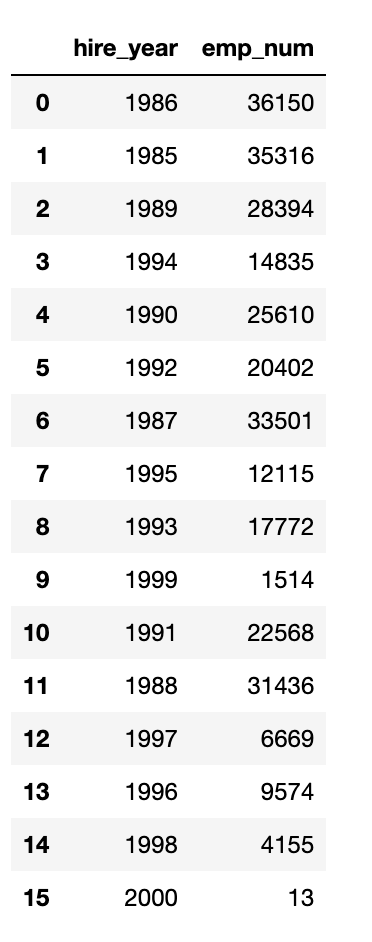

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

In [68]:
df_sorted = df.sort_values(by='hire_date', inplace=False)

In [69]:
df_sorted

,hire_date,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


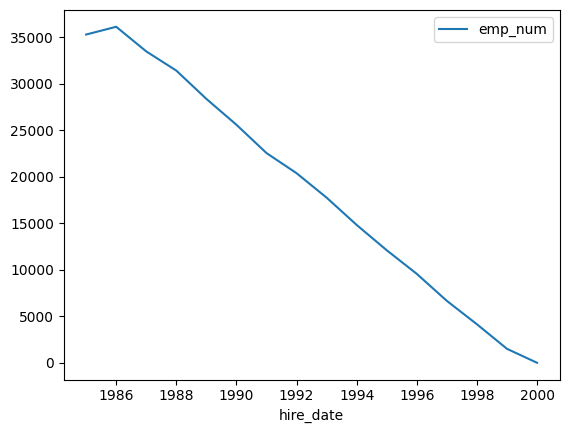

In [71]:
df_sorted.plot(x='hire_date', y='emp_num');

Очікуваний результат:

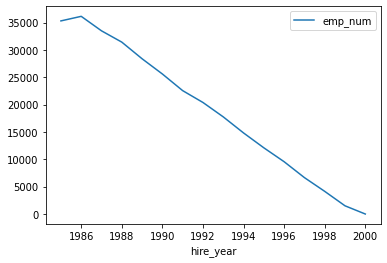

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [86]:
sql_title="""
SELECT timestampdiff (YEAR, from_date, to_date) as duration, from_date, to_date
FROM titles
WHERE title='Engineer' and to_date not like '9999-01-01'
"""

In [89]:
df_years = pd.read_sql(sql_title, con)

C:\Users\yevhe\AppData\Local\Temp\ipykernel_32644\498892684.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_years = pd.read_sql(sql_title, con)


In [90]:
df_years

,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


Очікуваний результат:

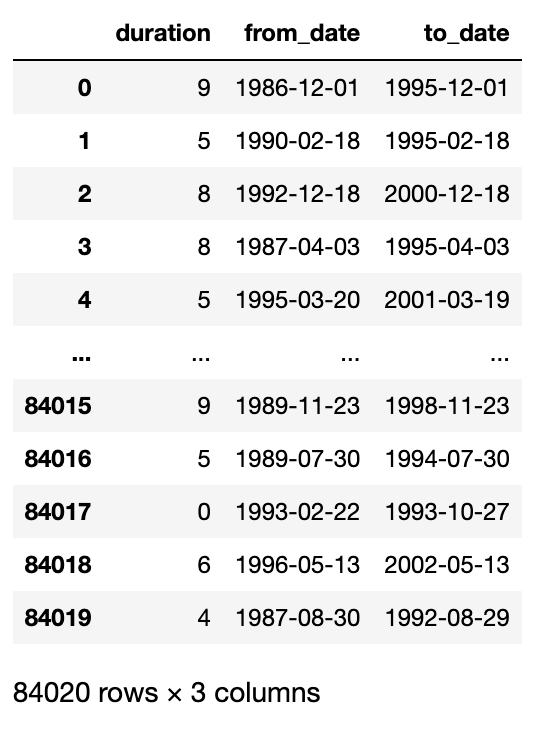

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

Text(0, 0.5, 'Number of employees')

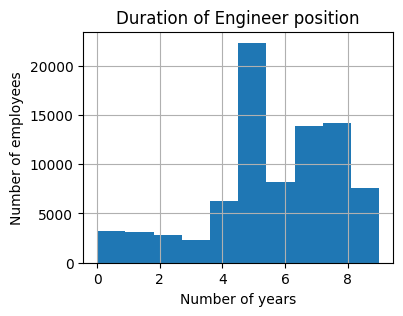

In [103]:
df_years.hist(figsize=(4,3))
plt.title('Duration of Engineer position')
plt.xlabel('Number of years')
plt.ylabel('Number of employees')

Очікуваний результат:

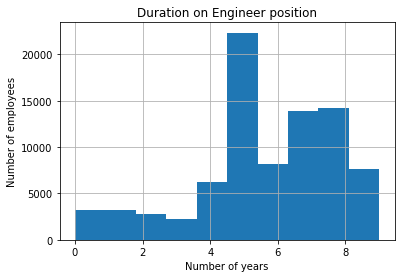

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [ ]:
con.close()